# MCS Occultation Regime Probability Analysis

This notebook calculates the probability of each MCS planet to be in different occultation regimes:
- **True Eclipse** (b < 1-k): Full eclipse/transit (planet passes well within stellar disk)
- **Grazing Eclipse** (1-k < b < 1+k): Partial eclipse (planet partially overlaps stellar disk)
- **False Eclipse** (b > 1+k): No eclipse/transit (planet does not overlap stellar disk)

The analysis incorporates uncertainty in k (Rp/Rs) through Monte Carlo sampling.

## 1. Import Libraries and Load Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [30]:
# Load MCMC results for eclipse impact parameters
mcmc_df = pd.read_csv('../results/mcs_eclipse_impact_parameter_mcmc.csv')
print(f"Loaded {len(mcmc_df)} planets from MCMC results")
print(f"Columns: {list(mcmc_df.columns)}")

# Check if quantiles column exists
if 'b_occ_quantiles' in mcmc_df.columns:
    print(f"\n✓ Found b_occ_quantiles column - will use full posterior distributions")
    print(f"  Sample quantiles for first planet: {mcmc_df.iloc[0]['b_occ_quantiles'][:100]}...")
else:
    print(f"\n✗ b_occ_quantiles column not found - will approximate with Gaussian")

mcmc_df.head()

Loaded 805 planets from MCMC results
Columns: ['Planet', 'Dataset', 'eclipse_observed', 'b_occ_median', 'b_occ_16', 'b_occ_84', 'b_occ_std', 'b_occ_err_lower', 'b_occ_err_upper', 'b_occ_quantiles', 'k_rp_rs', 'one_minus_k', 'one_plus_k', 'acceptance_fraction']

✓ Found b_occ_quantiles column - will use full posterior distributions
  Sample quantiles for first planet: 0.000002,0.001619,0.004419,0.009413,0.013582,0.017503,0.021417,0.024810,0.027824,0.031334,0.034560,0...


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,b_occ_quantiles,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction
0,K2-232b,MCS,False,0.122964,0.051115,0.195137,0.070489,0.071849,0.072173,"0.000002,0.001619,0.004419,0.009413,0.013582,0...",0.088110,0.911890,1.088110,0.463021
1,Qatar-10b,MCS,False,0.335221,0.227148,0.446392,0.111924,0.108073,0.111170,"0.012816,0.098566,0.124297,0.140166,0.152169,0...",0.126500,0.873500,1.126500,0.501000
2,WASP-60b,MCS,False,0.363733,0.143846,0.640743,0.251452,0.219886,0.277010,"0.000118,0.012809,0.024377,0.035674,0.046934,0...",0.077523,0.922477,1.077523,0.481177
3,WASP-20b,MCS,False,0.699661,0.553424,0.807040,0.152059,0.146238,0.107378,"0.048650,0.247038,0.310938,0.354044,0.383664,0...",0.107930,0.892070,1.107930,0.497948
4,HATS-52b,MCS,False,0.450944,0.323198,0.591627,0.138708,0.127745,0.140683,"0.018599,0.144882,0.181184,0.205663,0.222042,0...",0.135200,0.864800,1.135200,0.495969


In [31]:
# Load MCS catalog with k values and uncertainties
mcs_df = pd.read_csv('../../data/raw/Ariel_MCS_Known_2025-07-18.csv')
print(f"\nLoaded {len(mcs_df)} planets from MCS catalog")
print(f"Columns with Rp/Rs: {[c for c in mcs_df.columns if 'Rp/Rs' in c]}")
mcs_df[['Planet Name', 'Rp/Rs', 'Rp/Rs Error Lower', 'Rp/Rs Error Upper']].head()


Loaded 808 planets from MCS catalog
Columns with Rp/Rs: ['Rp/Rs', 'Rp/Rs Error Lower', 'Rp/Rs Error Upper']


,Planet Name,Rp/Rs,Rp/Rs Error Lower,Rp/Rs Error Upper
0,K2-232b,0.088110,-0.000170,0.000310
1,Qatar-10b,0.126500,-0.001000,0.001000
2,WASP-60b,0.077523,-0.003870,0.003870
3,WASP-20b,0.107930,-0.001066,0.001066
4,HATS-52b,0.135200,-0.002800,0.002800


## 2. Merge Datasets

In [32]:
# Merge the datasets
# The MCMC dataframe has 'Planet' column, the MCS catalog has 'Planet Name'
merged_df = mcmc_df.merge(
    mcs_df[['Planet Name', 'Rp/Rs', 'Rp/Rs Error Lower', 'Rp/Rs Error Upper']],
    left_on='Planet',
    right_on='Planet Name',
    how='left'
)

print(f"\nMerged dataset: {len(merged_df)} planets")
print(f"\nPlanets with k uncertainty data: {merged_df['Rp/Rs'].notna().sum()}")
print(f"Planets missing k data: {merged_df['Rp/Rs'].isna().sum()}")

# Check for any discrepancies
if merged_df['Rp/Rs'].isna().any():
    print("\nWarning: Some planets are missing k values:")
    print(merged_df[merged_df['Rp/Rs'].isna()]['Planet'].tolist())

merged_df.head()


Merged dataset: 805 planets

Planets with k uncertainty data: 805
Planets missing k data: 0


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,b_occ_quantiles,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction,Planet Name,Rp/Rs,Rp/Rs Error Lower,Rp/Rs Error Upper
0,K2-232b,MCS,False,0.122964,0.051115,0.195137,0.070489,0.071849,0.072173,"0.000002,0.001619,0.004419,0.009413,0.013582,0...",0.088110,0.911890,1.088110,0.463021,K2-232b,0.088110,-0.000170,0.000310
1,Qatar-10b,MCS,False,0.335221,0.227148,0.446392,0.111924,0.108073,0.111170,"0.012816,0.098566,0.124297,0.140166,0.152169,0...",0.126500,0.873500,1.126500,0.501000,Qatar-10b,0.126500,-0.001000,0.001000
2,WASP-60b,MCS,False,0.363733,0.143846,0.640743,0.251452,0.219886,0.277010,"0.000118,0.012809,0.024377,0.035674,0.046934,0...",0.077523,0.922477,1.077523,0.481177,WASP-60b,0.077523,-0.003870,0.003870
3,WASP-20b,MCS,False,0.699661,0.553424,0.807040,0.152059,0.146238,0.107378,"0.048650,0.247038,0.310938,0.354044,0.383664,0...",0.107930,0.892070,1.107930,0.497948,WASP-20b,0.107930,-0.001066,0.001066
4,HATS-52b,MCS,False,0.450944,0.323198,0.591627,0.138708,0.127745,0.140683,"0.018599,0.144882,0.181184,0.205663,0.222042,0...",0.135200,0.864800,1.135200,0.495969,HATS-52b,0.135200,-0.002800,0.002800


## 3. Monte Carlo Sampling for Occultation Regime Probabilities

For each planet, we:
1. Sample k values from a distribution bounded by the upper and lower errors
2. Sample b values from the MCMC posterior (represented by median and 16/84 percentiles)
3. Calculate which regime each (k, b) pair falls into
4. Compute probabilities for each regime

In [33]:
def calculate_regime_probabilities(row, n_samples=100000):
    """
    Calculate probabilities for each occultation regime using Monte Carlo sampling.
    
    Parameters:
    -----------
    row : pandas.Series
        Row containing planet data with b and k information
    n_samples : int
        Number of Monte Carlo samples to draw
    
    Returns:
    --------
    dict : Dictionary with probabilities for each regime
    """
    # Extract k values and uncertainties
    k_nominal = row['Rp/Rs']
    k_err_lower = abs(row['Rp/Rs Error Lower'])  # Should be positive
    k_err_upper = abs(row['Rp/Rs Error Upper'])  # Should be positive
    
    # Handle missing k values
    if pd.isna(k_nominal):
        # Fall back to the k_rp_rs value from MCMC results if available
        k_nominal = row['k_rp_rs']
        k_err_lower = 0.01 * k_nominal  # Assume 1% uncertainty if not available
        k_err_upper = 0.01 * k_nominal
    
    # Sample k values using asymmetric normal distribution
    # We'll sample from normal and then use different std devs for upper and lower
    k_samples = np.zeros(n_samples)
    for i in range(n_samples):
        # Random sign determines if we sample above or below nominal
        if np.random.rand() < 0.5:
            # Sample below nominal (use lower error)
            k_samples[i] = np.random.normal(k_nominal, k_err_lower)
        else:
            # Sample above nominal (use upper error)
            k_samples[i] = np.random.normal(k_nominal, k_err_upper)
    
    # Ensure k values are positive and reasonable
    k_samples = np.clip(k_samples, 0.001, 1.0)
    
    # Sample b values from the MCMC posterior
    # Check if we have full quantile distribution
    if pd.notna(row.get('b_occ_quantiles', np.nan)):
        # Parse quantiles from comma-separated string
        quantiles = np.array([float(x) for x in row['b_occ_quantiles'].split(',')])
        
        # Sample from the empirical quantile distribution
        # Generate random percentiles and interpolate
        random_percentiles = np.random.uniform(0, 100, n_samples)
        percentile_grid = np.linspace(0, 100, len(quantiles))
        b_samples = np.interp(random_percentiles, percentile_grid, quantiles)
    else:
        # Fallback: Approximate as normal with mean = median, std = (84th - 16th) / 2
        b_median = row['b_occ_median']
        b_std = (row['b_occ_84'] - row['b_occ_16']) / 2.0
        b_samples = np.random.normal(b_median, b_std, n_samples)
        
        # Ensure b values are non-negative
        b_samples = np.abs(b_samples)
    
    # Calculate regime for each sample
    true_eclipse = b_samples < (1 - k_samples)  # b < 1-k: Full eclipse
    grazing_eclipse = (b_samples >= (1 - k_samples)) & (b_samples <= (1 + k_samples))  # 1-k <= b <= 1+k: Grazing
    false_eclipse = b_samples > (1 + k_samples)  # b > 1+k: No eclipse
    
    # Calculate probabilities
    p_true = np.mean(true_eclipse)
    p_grazing = np.mean(grazing_eclipse)
    p_false = np.mean(false_eclipse)
    
    return {
        'prob_false_eclipse': p_false,
        'prob_grazing_eclipse': p_grazing,
        'prob_true_eclipse': p_true,
        'k_mean': np.mean(k_samples),
        'k_std': np.std(k_samples),
        'b_mean': np.mean(b_samples),
        'b_std': np.std(b_samples)
    }

In [34]:
# Apply Monte Carlo calculation to all planets
print("Calculating occultation regime probabilities for all MCS planets...")
print("This may take a minute or two...\n")

regime_results = []
for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Processing planets"):
    result = calculate_regime_probabilities(row)
    result['Planet'] = row['Planet']
    result['eclipse_observed'] = row['eclipse_observed']
    result['b_occ_median'] = row['b_occ_median']
    result['k_nominal'] = row['Rp/Rs'] if pd.notna(row['Rp/Rs']) else row['k_rp_rs']
    regime_results.append(result)

# Create results dataframe
results_df = pd.DataFrame(regime_results)

# Reorder columns for clarity
results_df = results_df[[
    'Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal',
    'prob_false_eclipse', 'prob_grazing_eclipse', 'prob_true_eclipse',
    'b_mean', 'b_std', 'k_mean', 'k_std'
]]

print("\n✓ Calculation complete!")
results_df.head(10)

Calculating occultation regime probabilities for all MCS planets...
This may take a minute or two...



Processing planets: 100%|██████████| 805/805 [00:36<00:00, 22.26it/s]


✓ Calculation complete!


,Planet,eclipse_observed,b_occ_median,k_nominal,prob_false_eclipse,prob_grazing_eclipse,prob_true_eclipse,b_mean,b_std,k_mean,k_std
0,K2-232b,False,0.122964,0.088110,0.00000,0.00000,1.00000,0.126366,0.072610,0.088110,0.000250
1,Qatar-10b,False,0.335221,0.126500,0.00000,0.00194,0.99806,0.338706,0.116145,0.126503,0.001002
2,WASP-60b,False,0.363733,0.077523,0.01496,0.01988,0.96516,0.402090,0.275348,0.077520,0.003857
3,WASP-20b,False,0.699661,0.107930,0.00893,0.06112,0.92995,0.686487,0.157167,0.107928,0.001065
4,HATS-52b,False,0.450944,0.135200,0.00016,0.00868,0.99116,0.456462,0.143479,0.135194,0.002799
5,TOI-1820b,False,0.850486,0.077700,0.00000,0.10101,0.89899,0.851100,0.057039,0.077701,0.000899
6,TOI-2202b,False,0.322570,0.126500,0.00000,0.00000,1.00000,0.330318,0.068969,0.126499,0.001746
7,TOI-4087b,False,0.315544,0.107568,0.00000,0.00000,1.00000,0.316653,0.090699,0.107568,0.000454
8,WASP-2b,False,0.732471,0.128310,0.01047,0.11055,0.87898,0.715260,0.168073,0.128308,0.000988
9,K2-237b,False,0.186574,0.119000,0.00000,0.00000,1.00000,0.194073,0.099302,0.118999,0.002349


## 4. Summary Statistics

In [35]:
# Summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal MCS planets analyzed: {len(results_df)}")
print(f"\nObserved eclipses: {results_df['eclipse_observed'].sum()}")
print(f"Non-observed eclipses: {(~results_df['eclipse_observed']).sum()}")

print("\n" + "-"*80)
print("REGIME PROBABILITY STATISTICS (across all planets)")
print("-"*80)
print(f"\nMean probabilities:")
print(f"  True Eclipse (b < 1-k):      {results_df['prob_true_eclipse'].mean():.3f}")
print(f"  Grazing Eclipse (1-k<b<1+k): {results_df['prob_grazing_eclipse'].mean():.3f}")
print(f"  False Eclipse (b > 1+k):     {results_df['prob_false_eclipse'].mean():.3f}")

# Count planets by dominant regime
results_df['dominant_regime'] = results_df[['prob_false_eclipse', 'prob_grazing_eclipse', 'prob_true_eclipse']].idxmax(axis=1)
results_df['dominant_regime'] = results_df['dominant_regime'].str.replace('prob_', '').str.replace('_', ' ').str.title()

print(f"\n" + "-"*80)
print("PLANETS BY DOMINANT REGIME (highest probability)")
print("-"*80)
print(results_df['dominant_regime'].value_counts())

# High confidence classifications (>80% probability)
print(f"\n" + "-"*80)
print("HIGH CONFIDENCE CLASSIFICATIONS (>80% probability)")
print("-"*80)
high_conf_true = results_df[results_df['prob_true_eclipse'] > 0.8]
high_conf_grazing = results_df[results_df['prob_grazing_eclipse'] > 0.8]
high_conf_false = results_df[results_df['prob_false_eclipse'] > 0.8]

print(f"\nTrue Eclipse (>80%): {len(high_conf_true)} planets")
print(f"Grazing Eclipse (>80%): {len(high_conf_grazing)} planets")
print(f"False Eclipse (>80%): {len(high_conf_false)} planets")

SUMMARY STATISTICS

Total MCS planets analyzed: 805

Observed eclipses: 98
Non-observed eclipses: 707

--------------------------------------------------------------------------------
REGIME PROBABILITY STATISTICS (across all planets)
--------------------------------------------------------------------------------

Mean probabilities:
  True Eclipse (b < 1-k):      0.891
  Grazing Eclipse (1-k<b<1+k): 0.041
  False Eclipse (b > 1+k):     0.029

--------------------------------------------------------------------------------
PLANETS BY DOMINANT REGIME (highest probability)
--------------------------------------------------------------------------------
dominant_regime
True Eclipse       746
False Eclipse       41
Grazing Eclipse     18
Name: count, dtype: int64

--------------------------------------------------------------------------------
HIGH CONFIDENCE CLASSIFICATIONS (>80% probability)
--------------------------------------------------------------------------------

True Eclipse (

## 5. Visualizations

In [23]:
# # Create a comprehensive visualization
# fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # 1. Distribution of regime probabilities
# ax = axes[0, 0]
# results_df[['prob_false_eclipse', 'prob_grazing_eclipse', 'prob_true_eclipse']].hist(
#     bins=30, ax=ax, alpha=0.7, label=['False', 'Grazing', 'True']
# )
# ax.set_xlabel('Probability')
# ax.set_ylabel('Number of Planets')
# ax.set_title('Distribution of Regime Probabilities')
# ax.legend(['False Eclipse', 'Grazing Eclipse', 'True Eclipse'])
# ax.grid(alpha=0.3)

# # 2. Stacked bar chart showing probability composition
# ax = axes[0, 1]
# sorted_results = results_df.sort_values('prob_true_eclipse', ascending=False).head(30)
# x_pos = np.arange(len(sorted_results))
# ax.bar(x_pos, sorted_results['prob_false_eclipse'], label='False', color='#e74c3c', alpha=0.8)
# ax.bar(x_pos, sorted_results['prob_grazing_eclipse'], 
#        bottom=sorted_results['prob_false_eclipse'], label='Grazing', color='#f39c12', alpha=0.8)
# ax.bar(x_pos, sorted_results['prob_true_eclipse'], 
#        bottom=sorted_results['prob_false_eclipse'] + sorted_results['prob_grazing_eclipse'],
#        label='True', color='#27ae60', alpha=0.8)
# ax.set_xlabel('Planet Index (sorted by True Eclipse probability)')
# ax.set_ylabel('Cumulative Probability')
# ax.set_title('Top 30 Planets: Regime Probability Composition')
# ax.legend()
# ax.grid(alpha=0.3, axis='y')

# # 3. b vs k scatter plot colored by dominant regime
# ax = axes[1, 0]
# scatter = ax.scatter(results_df['k_nominal'], results_df['b_occ_median'], 
#                      c=results_df['prob_true_eclipse'], cmap='RdYlGn', 
#                      s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
# ax.set_xlabel('k (Rp/Rs)')
# ax.set_ylabel('b (Impact Parameter)')
# ax.set_title('Impact Parameter vs Planet-Star Radius Ratio')
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('P(True Eclipse)')
# ax.grid(alpha=0.3)

# # Add regime boundaries
# k_range = np.linspace(results_df['k_nominal'].min(), results_df['k_nominal'].max(), 100)
# ax.plot(k_range, 1 - k_range, 'r--', alpha=0.5, linewidth=2, label='b = 1-k')
# ax.plot(k_range, 1 + k_range, 'g--', alpha=0.5, linewidth=2, label='b = 1+k')
# ax.legend()

# # 4. Pie chart of dominant regimes
# ax = axes[1, 1]
# regime_counts = results_df['dominant_regime'].value_counts()
# colors = {'False Eclipse': '#e74c3c', 'Grazing Eclipse': '#f39c12', 'True Eclipse': '#27ae60'}
# pie_colors = [colors[regime] for regime in regime_counts.index]
# ax.pie(regime_counts, labels=regime_counts.index, autopct='%1.1f%%', 
#        colors=pie_colors, startangle=90)
# ax.set_title('Distribution of Dominant Regimes')

# plt.tight_layout()
# plt.savefig('../results/mcs_occultation_regime_analysis.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\n✓ Visualizations saved to: ../results/mcs_occultation_regime_analysis.png")

## 6. Detailed Results Tables

In [39]:
# Show top candidates for each regime
print("="*80)
print("TOP 10 CANDIDATES FOR EACH REGIME")
print("="*80)

print("\n" + "-"*80)
print("TOP 10: Highest Probability of TRUE ECLIPSE (b < 1-k)")
print("-"*80)
top_true = results_df.nlargest(10, 'prob_true_eclipse')[[
    'Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal', 'prob_true_eclipse'
]]
print(top_true.to_string(index=False))

print("\n" + "-"*80)
print("TOP 10: Highest Probability of GRAZING ECLIPSE (1-k < b < 1+k)")
print("-"*80)
top_grazing = results_df.nlargest(10, 'prob_grazing_eclipse')[[
    'Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal', 'prob_grazing_eclipse'
]]
print(top_grazing.to_string(index=False))

print("\n" + "-"*80)
print("TOP 10: Highest Probability of FALSE ECLIPSE (b > 1+k)")
print("-"*80)
top_false = results_df.nlargest(10, 'prob_false_eclipse')[[
    'Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal', 'prob_false_eclipse'
]]
print(top_false.to_string(index=False))

TOP 10 CANDIDATES FOR EACH REGIME

--------------------------------------------------------------------------------
TOP 10: Highest Probability of TRUE ECLIPSE (b < 1-k)
--------------------------------------------------------------------------------
   Planet  eclipse_observed  b_occ_median  k_nominal  prob_true_eclipse
  K2-232b             False      0.122964   0.088110                1.0
TOI-2202b             False      0.322570   0.126500                1.0
TOI-4087b             False      0.315544   0.107568                1.0
  K2-237b             False      0.186574   0.119000                1.0
WASP-107b             False      0.093930   0.146359                1.0
WASP-197b             False      0.412733   0.062700                1.0
 WASP-61b             False      0.099821   0.089455                1.0
 WASP-37b             False      0.193152   0.118848                1.0
HD191939b             False      0.613833   0.033190                1.0
 WASP-17b              True  

Creating visualization for True Eclipse candidates...


/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14907/2266638573.py:136: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14907/2266638573.py:137: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


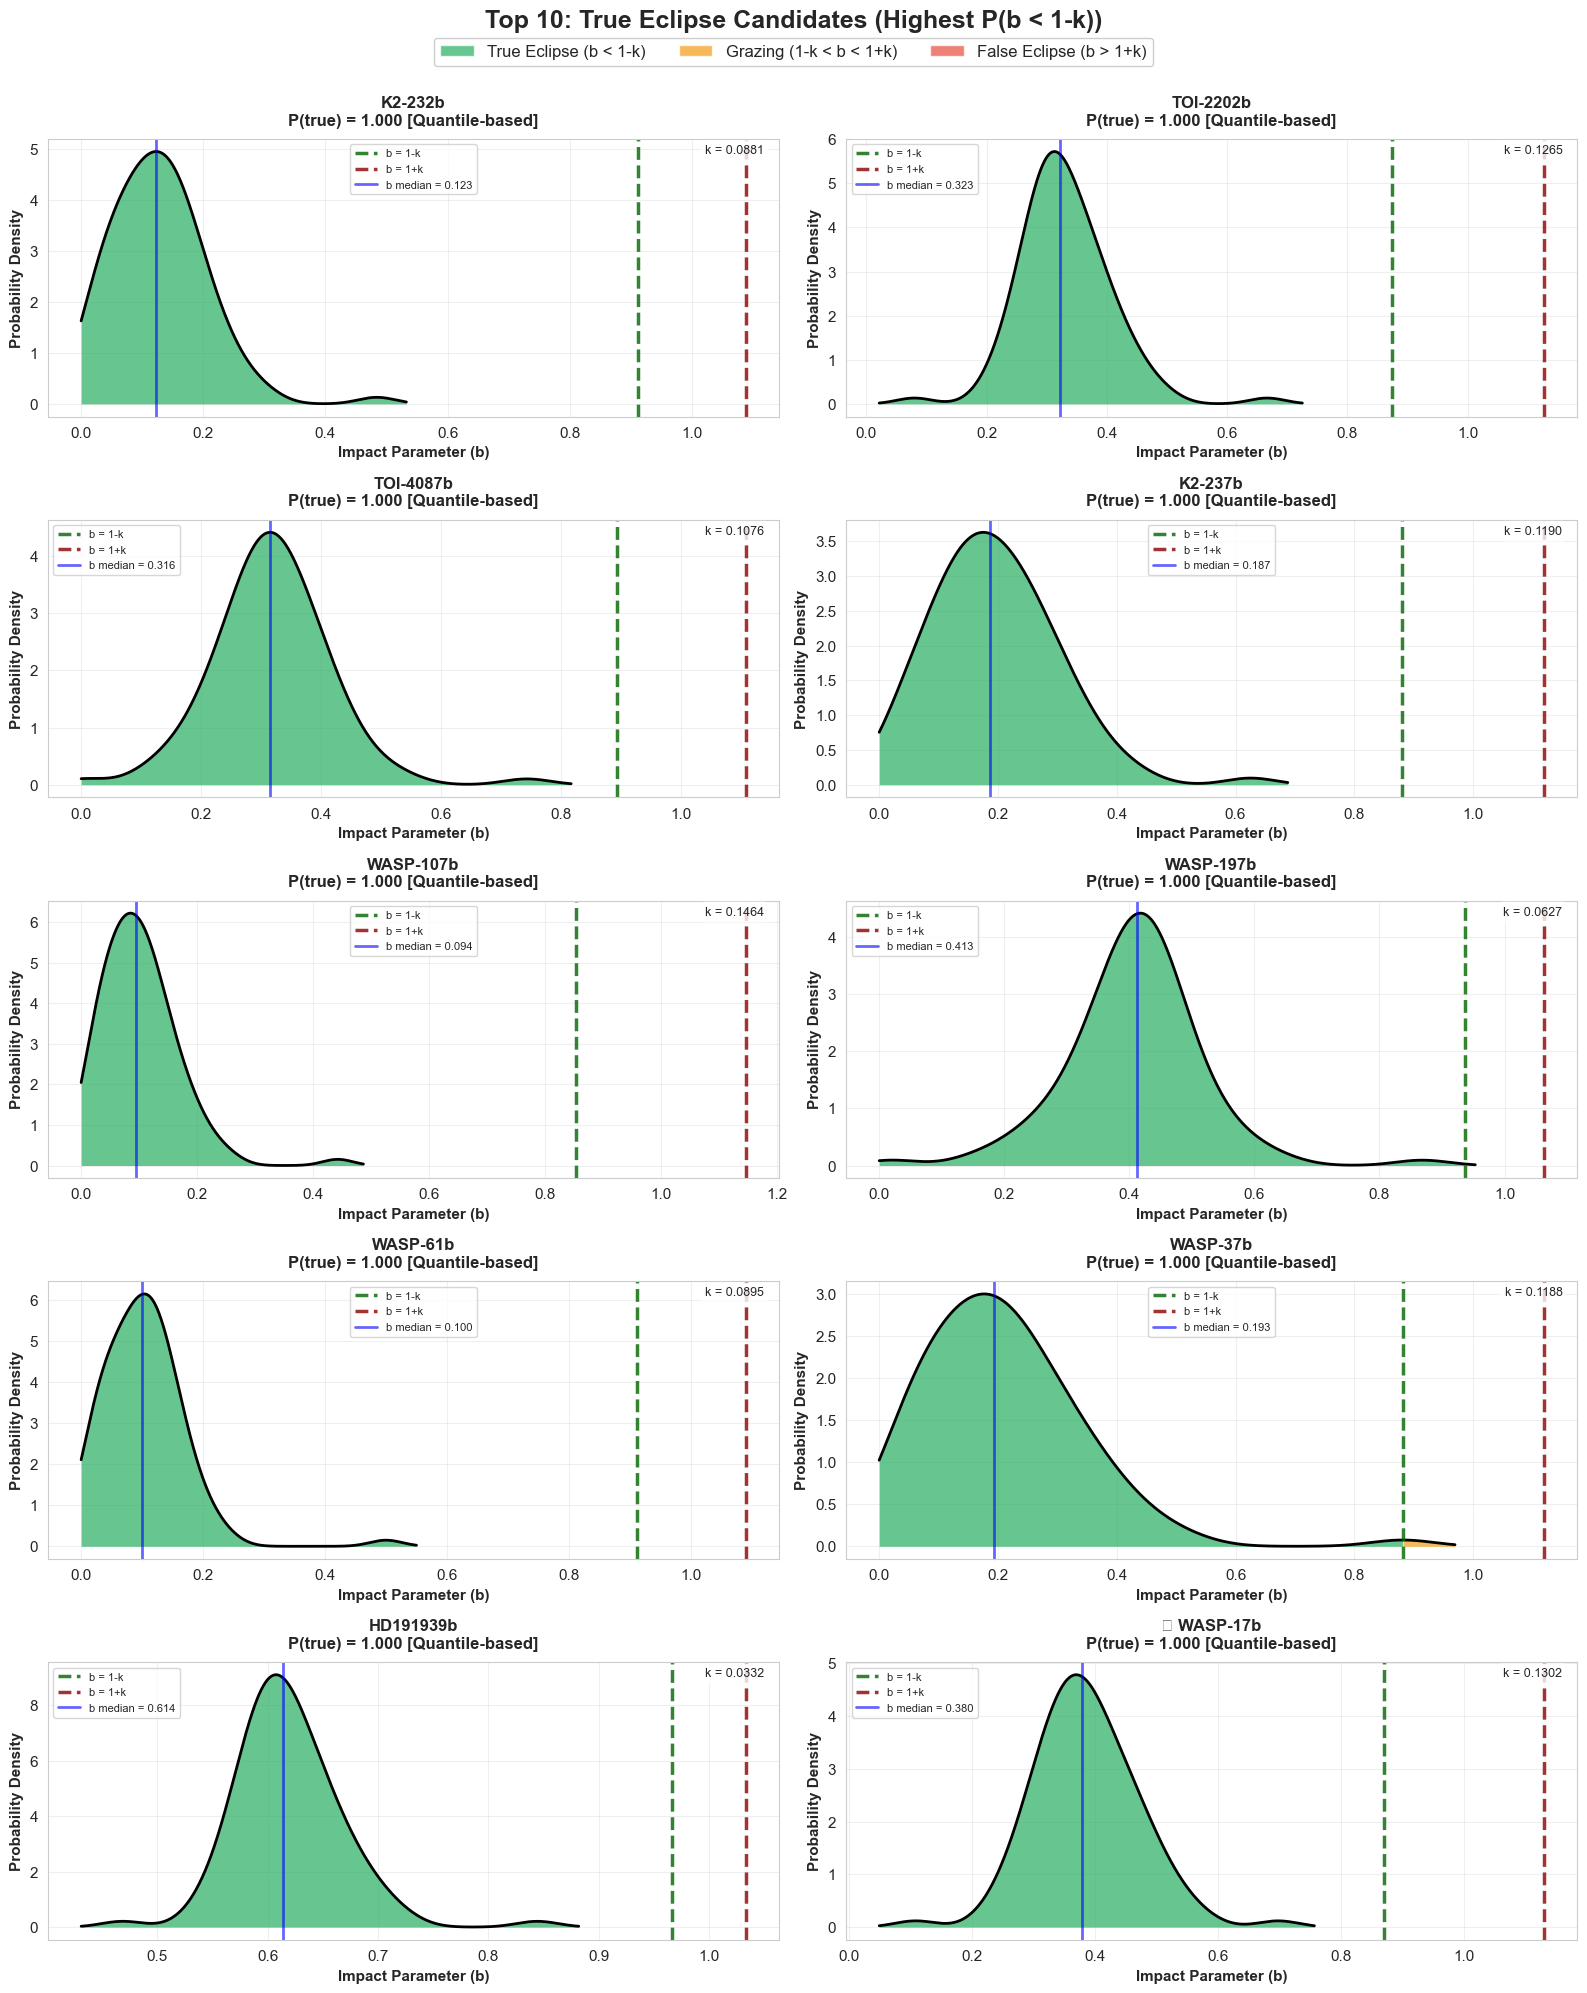


✓ Saved: ../results/mcs_top10_true_eclipse.png

Creating visualization for Grazing Eclipse candidates...


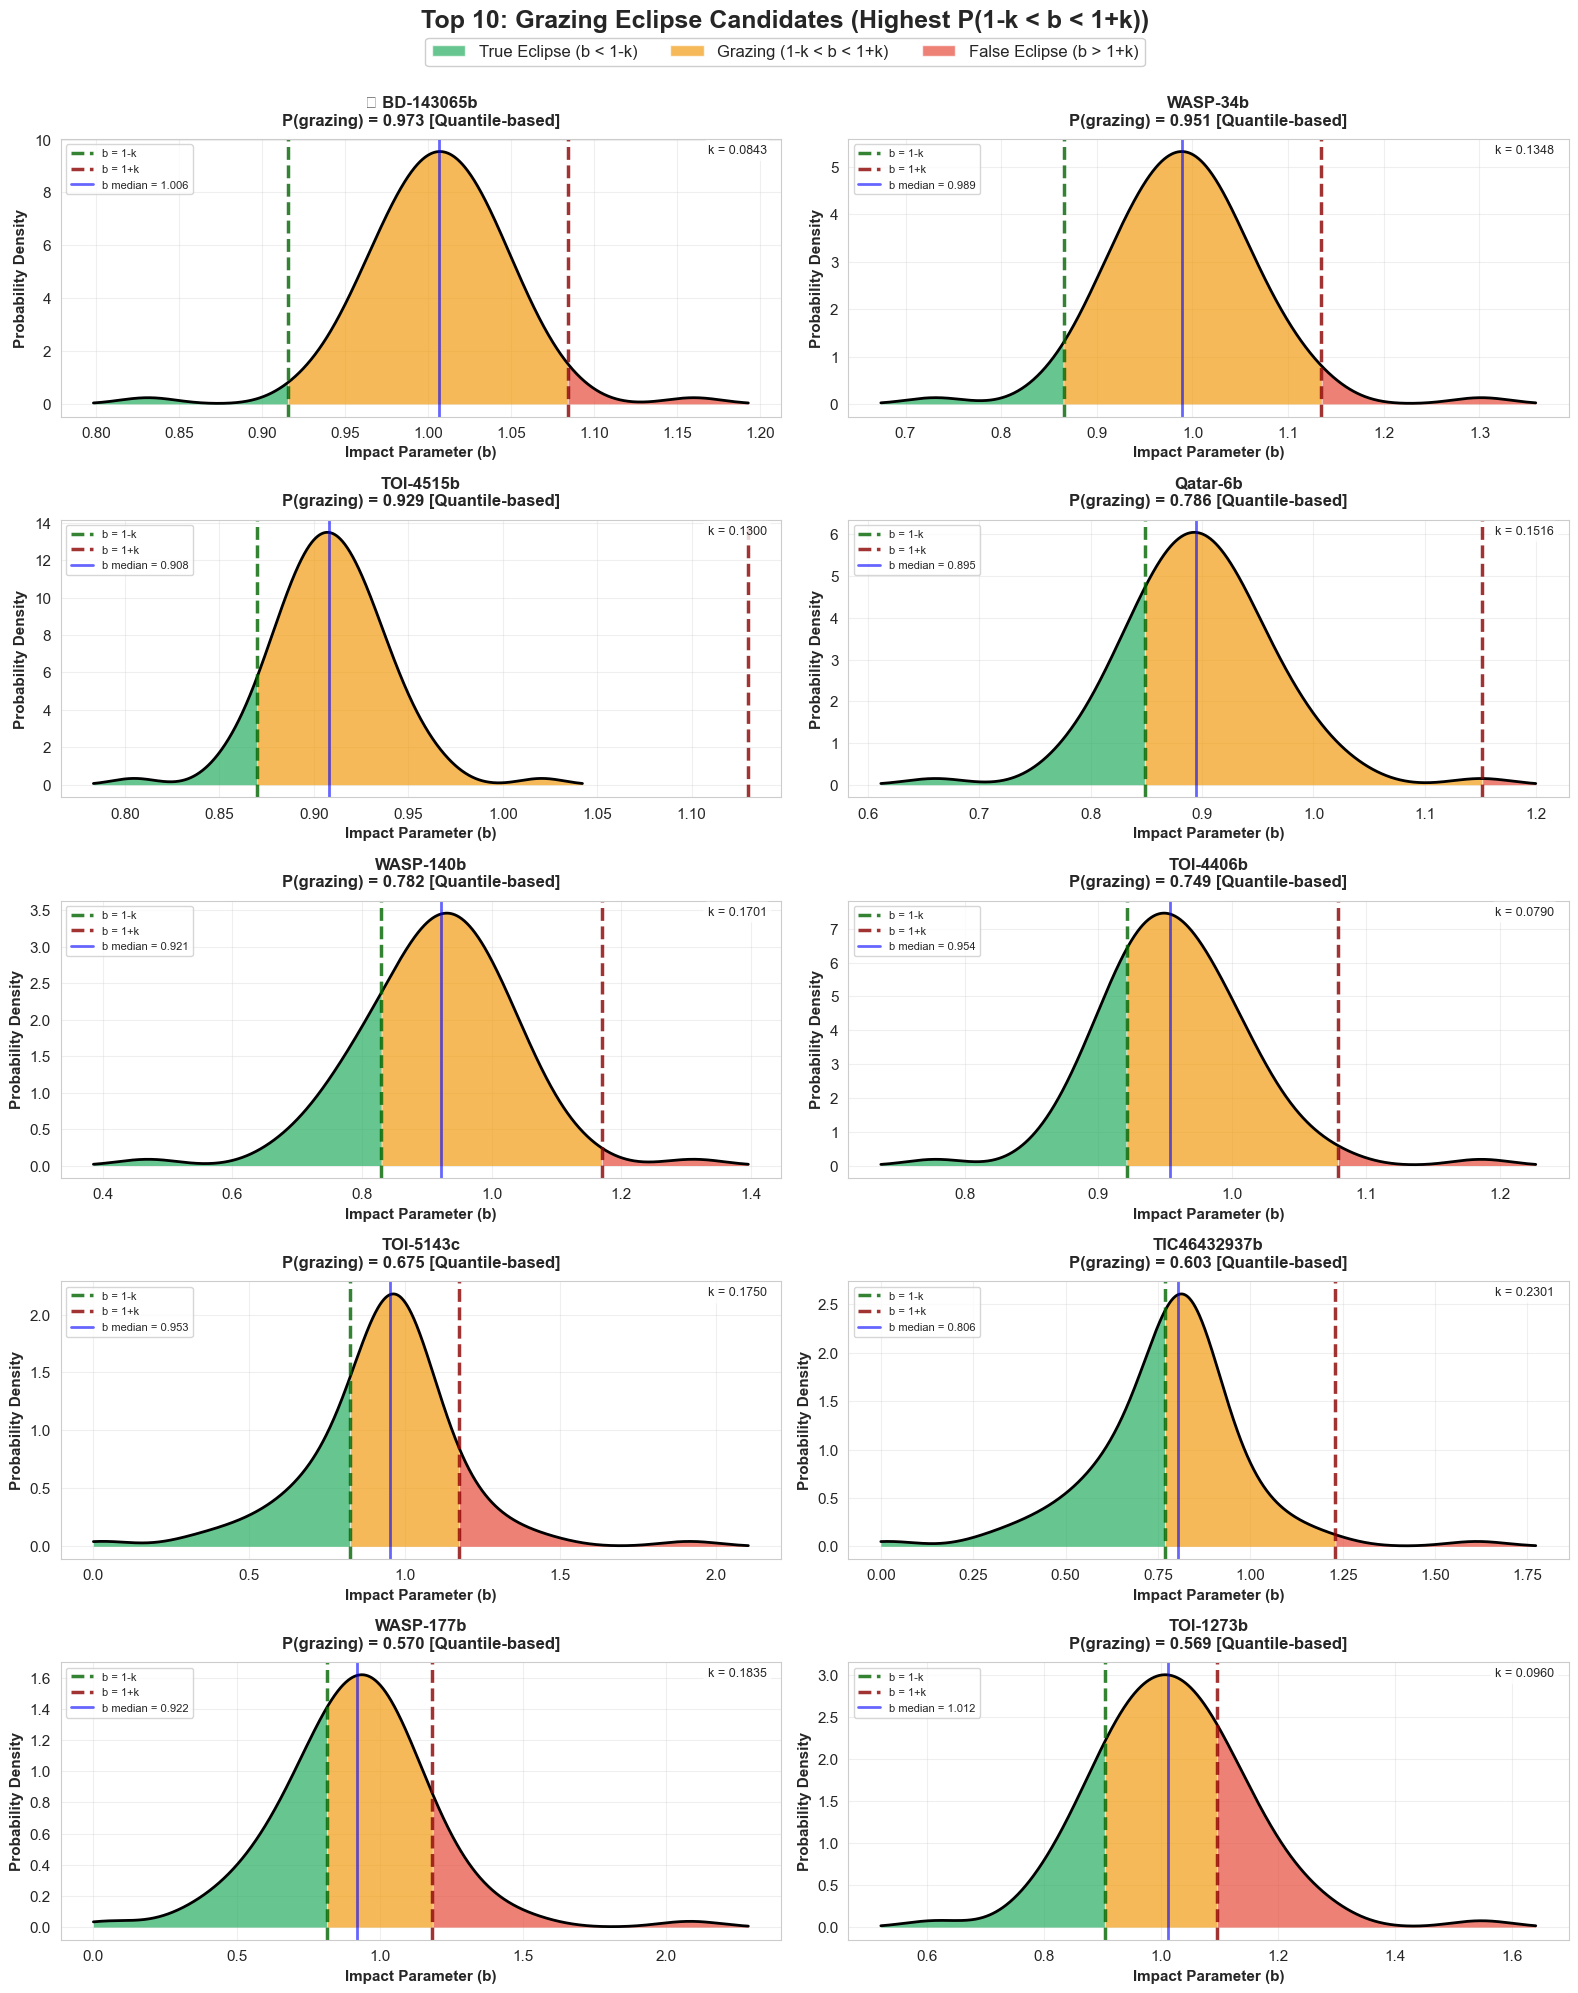


✓ Saved: ../results/mcs_top10_grazing_eclipse.png

Creating visualization for False Eclipse candidates...


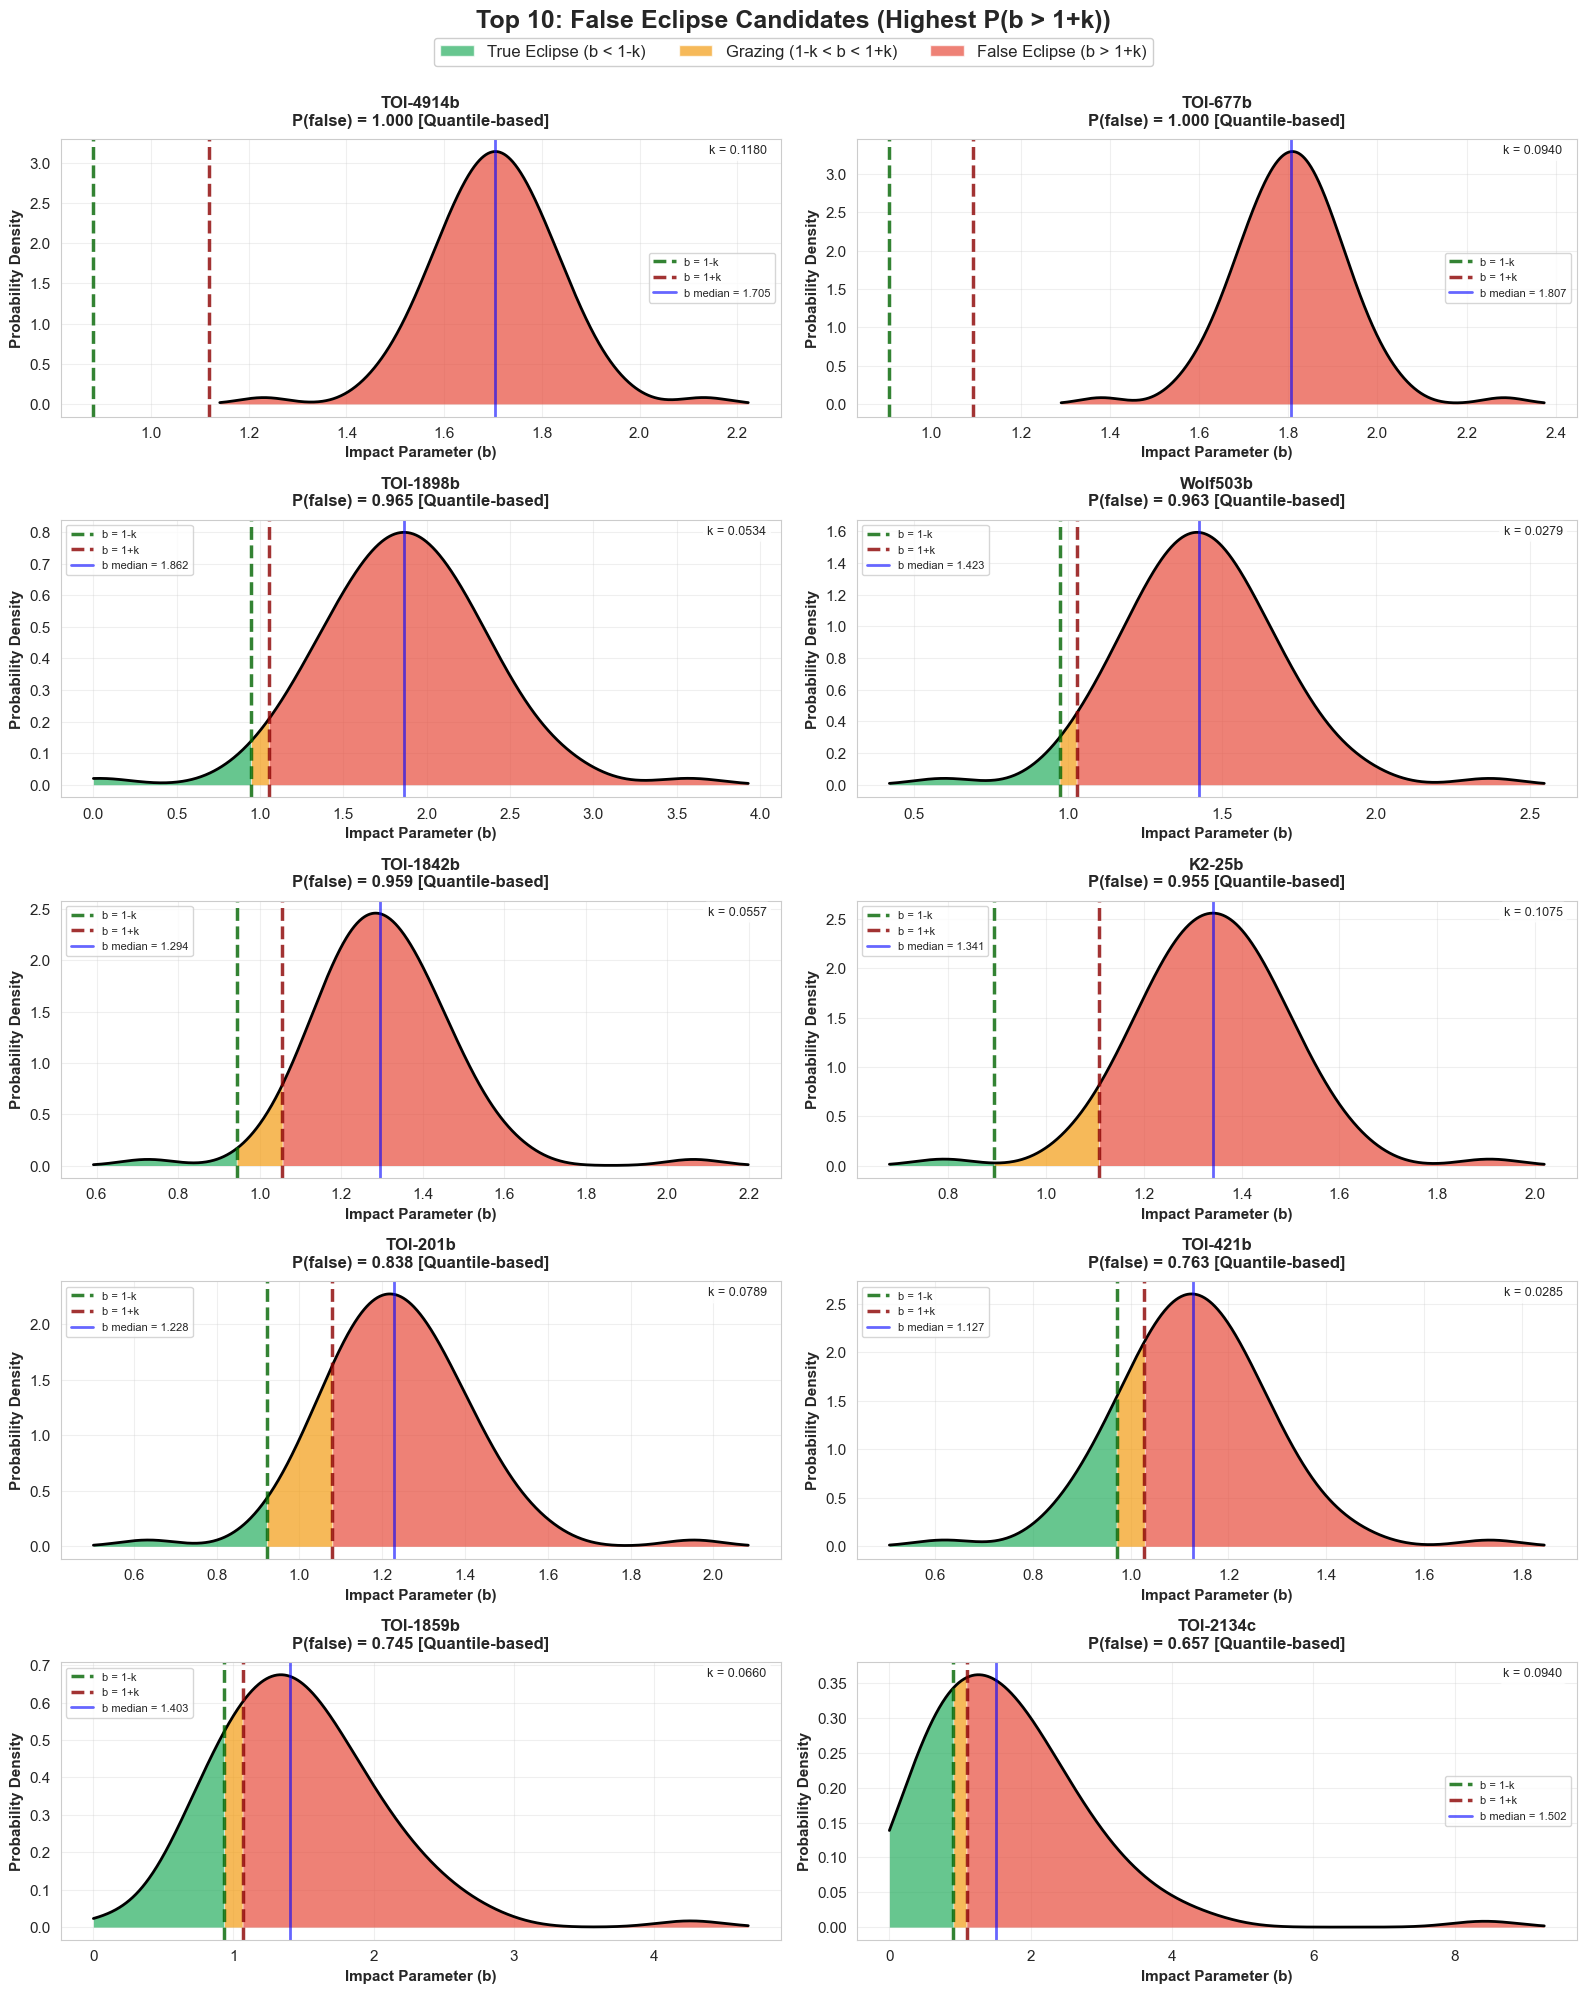


✓ Saved: ../results/mcs_top10_false_eclipse.png

✓ All three visualizations completed!


In [42]:
from scipy import stats

# Get top 10 for each regime
top_10_true = results_df.nlargest(10, 'prob_true_eclipse')
top_10_grazing = results_df.nlargest(10, 'prob_grazing_eclipse')
top_10_false = results_df.nlargest(10, 'prob_false_eclipse')

def plot_regime_distributions_grid(top_10_data, title, regime_type, filename):
    """
    Plot distributions for top 10 planets in a grid layout with colored regions.
    Uses actual quantile-based posterior if available, otherwise Gaussian approximation.
    
    Parameters:
    -----------
    top_10_data : DataFrame with top 10 planets
    title : str, plot title
    regime_type : str, one of 'true', 'grazing', 'false'
    filename : str, filename to save the figure
    """
    # Create a 5x2 grid (5 rows, 2 columns)
    fig, axes = plt.subplots(5, 2, figsize=(16, 20))
    axes = axes.flatten()
    
    # Plot each planet's distribution
    for i, (idx, planet) in enumerate(top_10_data.iterrows()):
        ax = axes[i]
        
        # Get k value
        k = planet['k_nominal']
        
        # Check if we have quantiles for this planet
        planet_name = planet['Planet']
        planet_row = merged_df[merged_df['Planet'] == planet_name].iloc[0]
        
        if pd.notna(planet_row.get('b_occ_quantiles', np.nan)):
            # Use actual quantile-based posterior
            quantiles = np.array([float(x) for x in planet_row['b_occ_quantiles'].split(',')])
            
            # Get median for plotting
            b_median = planet['b_occ_median']
            
            # Create x range from quantile distribution
            x_min = max(0, quantiles.min() - 0.1 * (quantiles.max() - quantiles.min()))
            x_max = quantiles.max() + 0.1 * (quantiles.max() - quantiles.min())
            x = np.linspace(x_min, x_max, 1000)
            
            # Estimate PDF from quantiles using KDE (Kernel Density Estimation)
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(quantiles)
            pdf = kde(x)
            
            distribution_type = "Quantile-based"
        else:
            # Fallback to Gaussian approximation
            b_median = planet['b_occ_median']
            b_std = planet['b_std']
            
            # Create x range for plotting
            x_min = max(0, b_median - 4*b_std)
            x_max = b_median + 4*b_std
            x = np.linspace(x_min, x_max, 1000)
            
            # Calculate Gaussian PDF
            pdf = stats.norm.pdf(x, b_median, b_std)
            
            distribution_type = "Gaussian approx."
        
        # Calculate boundaries
        boundary_lower = 1 - k  # True/Grazing boundary
        boundary_upper = 1 + k  # Grazing/False boundary
        
        # Fill regions with different colors
        # True eclipse region (b < 1-k) - green
        mask_true = x < boundary_lower
        if mask_true.any():
            ax.fill_between(x[mask_true], 0, pdf[mask_true], 
                           color='#27ae60', alpha=0.7, linewidth=0)
        
        # Grazing region (1-k < b < 1+k) - orange
        mask_grazing = (x >= boundary_lower) & (x <= boundary_upper)
        if mask_grazing.any():
            ax.fill_between(x[mask_grazing], 0, pdf[mask_grazing], 
                           color='#f39c12', alpha=0.7, linewidth=0)
        
        # False eclipse region (b > 1+k) - red
        mask_false = x > boundary_upper
        if mask_false.any():
            ax.fill_between(x[mask_false], 0, pdf[mask_false], 
                           color='#e74c3c', alpha=0.7, linewidth=0)
        
        # Plot the full distribution outline
        ax.plot(x, pdf, 'k-', linewidth=2)
        
        # Add vertical lines for boundaries (ymin=0, ymax=1 spans full axis height)
        ax.axvline(boundary_lower, ymin=0, ymax=1, color='darkgreen', 
                  linestyle='--', linewidth=2.5, alpha=0.8, label='b = 1-k')
        ax.axvline(boundary_upper, ymin=0, ymax=1, color='darkred', 
                  linestyle='--', linewidth=2.5, alpha=0.8, label='b = 1+k')
        
        # Add vertical line for median
        ax.axvline(b_median, ymin=0, ymax=1, color='blue', 
                  linestyle='-', linewidth=2, alpha=0.6, label=f'b median = {b_median:.3f}')
        
        # Set labels and title
        planet_name = planet['Planet']
        prob_val = planet[f'prob_{regime_type}_eclipse']
        
        # Add star for observed eclipses
        star = '★ ' if planet['eclipse_observed'] else ''
        
        ax.set_title(f'{star}{planet_name}\nP({regime_type}) = {prob_val:.3f} [{distribution_type}]', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Impact Parameter (b)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='best')
        
        # Add text showing k value
        ax.text(0.98, 0.98, f'k = {k:.4f}', 
               transform=ax.transAxes, fontsize=9, va='top', ha='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add main title
    fig.suptitle(title, fontsize=18, fontweight='bold', y=0.995)
    
    # Add global legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27ae60', alpha=0.7, label='True Eclipse (b < 1-k)'),
        Patch(facecolor='#f39c12', alpha=0.7, label='Grazing (1-k < b < 1+k)'),
        Patch(facecolor='#e74c3c', alpha=0.7, label='False Eclipse (b > 1+k)')
    ]
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 0.985), ncol=3, fontsize=12, framealpha=0.95)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: {filename}")

# Create three separate figures
print("Creating visualization for True Eclipse candidates...")
plot_regime_distributions_grid(
    top_10_true, 
    'Top 10: True Eclipse Candidates (Highest P(b < 1-k))', 
    'true',
    '../results/mcs_top10_true_eclipse.png'
)

print("\nCreating visualization for Grazing Eclipse candidates...")
plot_regime_distributions_grid(
    top_10_grazing, 
    'Top 10: Grazing Eclipse Candidates (Highest P(1-k < b < 1+k))', 
    'grazing',
    '../results/mcs_top10_grazing_eclipse.png'
)

print("\nCreating visualization for False Eclipse candidates...")
plot_regime_distributions_grid(
    top_10_false, 
    'Top 10: False Eclipse Candidates (Highest P(b > 1+k))', 
    'false',
    '../results/mcs_top10_false_eclipse.png'
)

print("\n" + "="*80)
print("✓ All three visualizations completed!")
print("="*80)

### Top 10 Candidates Visualization by Regime

/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14907/73152499.py:78: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14907/73152499.py:79: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('../results/mcs_top10_by_regime.png', dpi=300, bbox_inches='tight')
/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


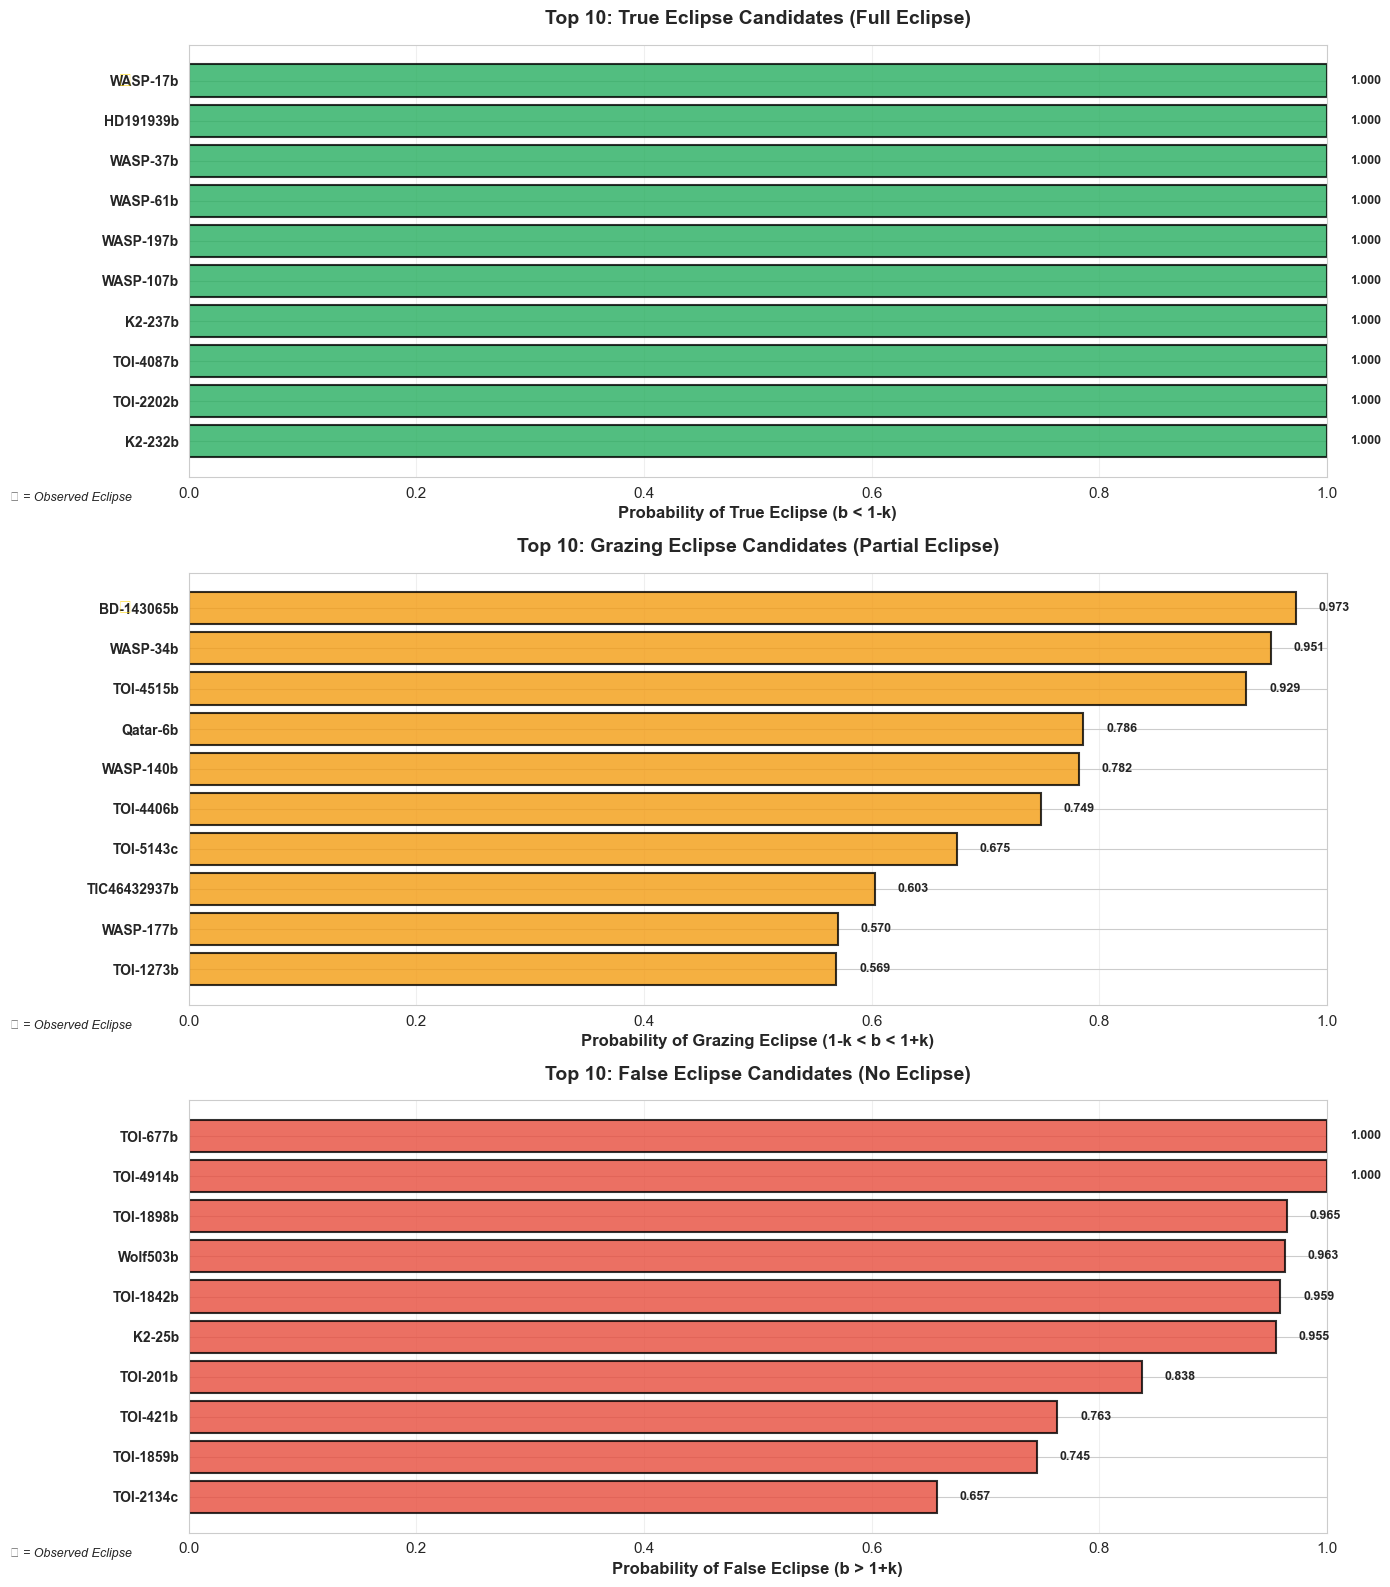


✓ Top 10 candidates visualization saved to: ../results/mcs_top10_by_regime.png


In [43]:
# Create visualizations for top 10 candidates in each regime
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# Get top 10 for each regime
top_10_true = results_df.nlargest(10, 'prob_true_eclipse').sort_values('prob_true_eclipse', ascending=True)
top_10_grazing = results_df.nlargest(10, 'prob_grazing_eclipse').sort_values('prob_grazing_eclipse', ascending=True)
top_10_false = results_df.nlargest(10, 'prob_false_eclipse').sort_values('prob_false_eclipse', ascending=True)

# 1. Top 10 True Eclipse Candidates
ax = axes[0]
bars = ax.barh(range(len(top_10_true)), top_10_true['prob_true_eclipse'], 
               color='#27ae60', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_10_true)))
ax.set_yticklabels(top_10_true['Planet'], fontsize=10, fontweight='bold')
ax.set_xlabel('Probability of True Eclipse (b < 1-k)', fontsize=12, fontweight='bold')
ax.set_title('Top 10: True Eclipse Candidates (Full Eclipse)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_10_true['prob_true_eclipse'])):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Add observed eclipse indicator
for i, (idx, row) in enumerate(top_10_true.iterrows()):
    if row['eclipse_observed']:
        ax.text(-0.05, i, '★', va='center', ha='right', fontsize=14, color='gold')

ax.text(-0.05, -1.5, '★ = Observed Eclipse', ha='right', fontsize=9, style='italic')

# 2. Top 10 Grazing Eclipse Candidates
ax = axes[1]
bars = ax.barh(range(len(top_10_grazing)), top_10_grazing['prob_grazing_eclipse'], 
               color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_10_grazing)))
ax.set_yticklabels(top_10_grazing['Planet'], fontsize=10, fontweight='bold')
ax.set_xlabel('Probability of Grazing Eclipse (1-k < b < 1+k)', fontsize=12, fontweight='bold')
ax.set_title('Top 10: Grazing Eclipse Candidates (Partial Eclipse)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_10_grazing['prob_grazing_eclipse'])):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Add observed eclipse indicator
for i, (idx, row) in enumerate(top_10_grazing.iterrows()):
    if row['eclipse_observed']:
        ax.text(-0.05, i, '★', va='center', ha='right', fontsize=14, color='gold')

ax.text(-0.05, -1.5, '★ = Observed Eclipse', ha='right', fontsize=9, style='italic')

# 3. Top 10 False Eclipse Candidates
ax = axes[2]
bars = ax.barh(range(len(top_10_false)), top_10_false['prob_false_eclipse'], 
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(top_10_false)))
ax.set_yticklabels(top_10_false['Planet'], fontsize=10, fontweight='bold')
ax.set_xlabel('Probability of False Eclipse (b > 1+k)', fontsize=12, fontweight='bold')
ax.set_title('Top 10: False Eclipse Candidates (No Eclipse)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_10_false['prob_false_eclipse'])):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Add observed eclipse indicator
for i, (idx, row) in enumerate(top_10_false.iterrows()):
    if row['eclipse_observed']:
        ax.text(-0.05, i, '★', va='center', ha='right', fontsize=14, color='gold')

ax.text(-0.05, -1.5, '★ = Observed Eclipse', ha='right', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('../results/mcs_top10_by_regime.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Top 10 candidates visualization saved to: ../results/mcs_top10_by_regime.png")

## 7. Save Results

In [44]:
# Save the complete results to CSV
output_path = '../results/mcs_occultation_regime_probabilities.csv'
results_df.to_csv(output_path, index=False)
print(f"✓ Results saved to: {output_path}")

# Also save a summary file with just the key information
summary_df = results_df[[
    'Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal',
    'prob_false_eclipse', 'prob_grazing_eclipse', 'prob_true_eclipse',
    'dominant_regime'
]].round(4)

summary_path = '../results/mcs_occultation_regime_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"✓ Summary saved to: {summary_path}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nResults files created:")
print(f"  1. {output_path}")
print(f"  2. {summary_path}")
print(f"  3. ../results/mcs_occultation_regime_analysis.png")

✓ Results saved to: ../results/mcs_occultation_regime_probabilities.csv
✓ Summary saved to: ../results/mcs_occultation_regime_summary.csv

ANALYSIS COMPLETE!

Results files created:
  1. ../results/mcs_occultation_regime_probabilities.csv
  2. ../results/mcs_occultation_regime_summary.csv
  3. ../results/mcs_occultation_regime_analysis.png


## 8. Identify Potentially Grazing Systems

Let's identify planets that have a significant probability of being in the grazing regime,
which could be particularly interesting for follow-up observations.

In [45]:
# Identify grazing candidates (>30% probability of grazing)
grazing_candidates = results_df[results_df['prob_grazing_eclipse'] > 0.30].sort_values(
    'prob_grazing_eclipse', ascending=False
)

print("="*80)
print(f"GRAZING ECLIPSE CANDIDATES (P(grazing) > 30%)")
print("="*80)
print(f"\nFound {len(grazing_candidates)} candidates\n")

display_cols = ['Planet', 'eclipse_observed', 'b_occ_median', 'k_nominal', 
                'prob_false_eclipse', 'prob_grazing_eclipse', 'prob_true_eclipse']
print(grazing_candidates[display_cols].to_string(index=False))

# Save grazing candidates
grazing_path = '../results/mcs_grazing_candidates.csv'
grazing_candidates.to_csv(grazing_path, index=False)
print(f"\n✓ Grazing candidates saved to: {grazing_path}")

GRAZING ECLIPSE CANDIDATES (P(grazing) > 30%)

Found 36 candidates

      Planet  eclipse_observed  b_occ_median  k_nominal  prob_false_eclipse  prob_grazing_eclipse  prob_true_eclipse
  BD-143065b              True      1.006438   0.084300             0.01750               0.97272            0.00978
    WASP-34b             False      0.989117   0.134807             0.01906               0.95080            0.03014
   TOI-4515b             False      0.908031   0.130000             0.00000               0.92908            0.07092
    Qatar-6b             False      0.895019   0.151600             0.00017               0.78588            0.21395
   WASP-140b             False      0.921414   0.170090             0.00920               0.78187            0.20893
   TOI-4406b             False      0.953661   0.079000             0.01271               0.74883            0.23846
   TOI-5143c             False      0.952735   0.175000             0.08902               0.67504            0.23

In [46]:
# Check for planets with unusual impact parameters
print("="*80)
print("DIAGNOSTIC: Checking for unusual impact parameters")
print("="*80)

# Check for negative impact parameters
negative_b = results_df[results_df['b_occ_median'] < 0]
if len(negative_b) > 0:
    print(f"\n⚠ WARNING: Found {len(negative_b)} planet(s) with NEGATIVE impact parameters:")
    print(negative_b[['Planet', 'b_occ_median', 'b_std', 'k_nominal', 
                      'prob_true_eclipse', 'prob_grazing_eclipse', 'prob_false_eclipse']])
    print("\nNote: Impact parameter b should be non-negative. Negative values indicate")
    print("potential issues with the MCMC fitting. These planets may need special attention.")

# Check for very large uncertainties
large_uncertainty = results_df[results_df['b_std'] > 0.5]
if len(large_uncertainty) > 0:
    print(f"\n⚠ INFO: Found {len(large_uncertainty)} planet(s) with large b uncertainty (σ > 0.5):")
    print(large_uncertainty[['Planet', 'b_occ_median', 'b_std', 'prob_true_eclipse', 
                             'prob_grazing_eclipse', 'prob_false_eclipse']].head(10))

# Specific check for TOI-1130c
toi_1130c = results_df[results_df['Planet'] == 'TOI-1130c']
if len(toi_1130c) > 0:
    print("\n" + "-"*80)
    print("SPECIFIC CASE: TOI-1130c")
    print("-"*80)
    print(toi_1130c[['Planet', 'b_occ_median', 'b_std', 'k_nominal', 
                     'prob_true_eclipse', 'prob_grazing_eclipse', 'prob_false_eclipse']].to_string(index=False))
    print("\nInterpretation:")
    print(f"  - The MCMC fit gave a negative b = {toi_1130c['b_occ_median'].values[0]:.3f}")
    print(f"  - This is physically impossible (impact parameter must be ≥ 0)")
    print(f"  - The code uses abs(b) in calculations, making it positive")
    print(f"  - k = {toi_1130c['k_nominal'].values[0]:.4f}, so 1-k = {1-toi_1130c['k_nominal'].values[0]:.4f}")
    print(f"  - With |b| ≈ {abs(toi_1130c['b_occ_median'].values[0]):.3f}, this suggests a high-probability true eclipse")
    print("\n  ⚠ RECOMMENDATION: Verify the MCMC results for this planet independently.")

DIAGNOSTIC: Checking for unusual impact parameters

⚠ INFO: Found 7 planet(s) with large b uncertainty (σ > 0.5):
        Planet  b_occ_median     b_std  prob_true_eclipse  \
235  TOI-2134c      1.502096  1.078123            0.26572   
247   TOI-199b      0.583578  0.578743            0.00000   
317  TOI-1859b      1.402619  0.560139            0.17841   
506   TOI-904b      0.650046  0.519354            0.73061   
515     K2-18b      0.737303  0.581515            0.63659   
596    K2-370b      0.990748  0.630528            0.47674   
795   TOI-836c      0.665449  0.517758            0.70365   

     prob_grazing_eclipse  prob_false_eclipse  
235               0.07728             0.65700  
247               0.00000             0.00000  
317               0.07660             0.74499  
506               0.04217             0.22722  
515               0.06260             0.30081  
596               0.06302             0.46024  
795               0.04013             0.25622  
